In [1]:
import os
import pydicom
from PIL import Image
import numpy as np
import tensorflow as tf
import logging
from sklearn.model_selection import train_test_split

logging.basicConfig(level=logging.INFO)


In [2]:
import os
import pydicom
from pydicom.errors import InvalidDicomError

def get_dicom_image_size(filepath):
    if not os.path.exists(filepath):
        print(f"File does not exist: {filepath}")
        return None
    
    try:
        # Load the DICOM file
        dicom_file = pydicom.dcmread(filepath)
        
        # Retrieve dimensions
        rows = dicom_file.Rows
        columns = dicom_file.Columns
        
        return (rows, columns)
    except InvalidDicomError:
        print("Not a valid DICOM file.")
        return None
    except AttributeError:
        print("DICOM file does not contain image size information.")
        return None

# Specify the path to your DICOM file
path_to_dicom = "/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/MRI-US-PatientImages/manifest-1706813151803/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0001/06-28-2009-NA-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2spcrstaxial oblProstate-90221/1-01.dcm"

# Get the size of the DICOM image
size = get_dicom_image_size(path_to_dicom)
if size:
    print(f"Image Size: {size[0]} x {size[1]} pixels")


Image Size: 256 x 256 pixels


In [2]:
import pydicom
import numpy as np
import logging
from PIL import Image
import tensorflow as tf

def load_dicom_image(path, img_size=256, use_rgb=False):
    try:
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array

        # Adjusting normalization based on the actual range of the pixel data
        max_pixel_value = np.max(image)
        if max_pixel_value > 0:  # Prevent division by zero
            image = image / max_pixel_value  # Normalize the image

        if use_rgb:
            # Convert to RGB if needed (some models may require 3 channels)
            image = np.stack([image] * 3, axis=-1)

        image = Image.fromarray((image * 255).astype(np.uint8))  # Scale to 0-255 to use PIL
        image = image.resize((img_size, img_size))
        image = np.array(image) / 255.0  # Normalize the image back to 0-1

        # Assert to ensure all values are between 0 and 1
        assert np.all((image >= 0) & (image <= 1)), "Image values should be in the range [0, 1]"

        return tf.convert_to_tensor(image, dtype=tf.float32)
    except Exception as e:
        logging.error(f"Failed to process image {path}: {e}")
        return None


In [ ]:
""" def process_patient_images(patient_folder, img_size=256):
    images = []
    try:
        for filename in os.listdir(patient_folder):
            if filename.endswith('.dcm'):
                path = os.path.join(patient_folder, filename)
                image = load_dicom_image(path, img_size=img_size)
                if image is not None:
                    images.append(image)
    except Exception as e:
        logging.warning(f"Error processing folder {patient_folder}: {e}")
    return images """

In [3]:
def process_patient_images(patient_folder, img_size=256):
    images = []
    try:
        for root, dirs, files in os.walk(patient_folder):
            for filename in files:
                if filename.endswith('.dcm'):
                    path = os.path.join(root, filename)
                    image = load_dicom_image(path, img_size=img_size)
                    if image is not None:
                        images.append(image)
    except Exception as e:
        logging.warning(f"Error processing folder {patient_folder}: {e}")
    return images

In [4]:
def process_data(folders, img_size, batch_size):
    all_images = []
    all_labels = []
    for folder_path, label in folders:
        images = process_patient_images(folder_path, img_size=img_size)
        all_images.extend(images)
        all_labels.extend([label] * len(images))
    
    dataset_images = tf.stack(all_images)
    dataset_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((dataset_images, dataset_labels)).shuffle(buffer_size=1024).batch(batch_size)
    class_counts = {1: all_labels.count(1), 0: all_labels.count(0)}
    return dataset, class_counts

In [5]:
def create_datasets(root_dir, img_size=256, batch_size=32, val_split=0.15, test_split=0.15):
    patient_folders = []
    for condition in os.listdir(root_dir):
        condition_path = os.path.join(root_dir, condition)
        if os.path.isdir(condition_path):
            label = 1 if condition.lower() == 'cancer' else 0
            for patient_folder_name in os.listdir(condition_path):
                patient_folder_path = os.path.join(condition_path, patient_folder_name)
                if os.path.isdir(patient_folder_path):
                    patient_folders.append((patient_folder_path, label))
                    logging.info(f"Added folder {patient_folder_path} with label {label}")

    initial_split = 1 - (val_split + test_split)
    train_folders, temp_folders = train_test_split(patient_folders, test_size=(val_split + test_split), random_state=42)
    val_folders, test_folders = train_test_split(temp_folders, test_size=test_split/(val_split + test_split), random_state=42)

    train_dataset, train_counts = process_data(train_folders, img_size, batch_size)
    val_dataset, val_counts = process_data(val_folders, img_size, batch_size)
    test_dataset, test_counts = process_data(test_folders, img_size, batch_size)
    
    print("Training Class Distribution:", train_counts)
    print("Validation Class Distribution:", val_counts)
    print("Testing Class Distribution:", test_counts)

    return train_dataset, val_dataset, test_dataset

In [6]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


In [7]:
train_dataset, val_dataset, test_dataset = create_datasets(root_dir='/Users/arjunmoorthy/24Spr_AMoorthy_healthai/data/applied_segs_final', img_size=256, batch_size=32)

INFO:root:Added folder /Users/arjunmoorthy/24Spr_AMoorthy_healthai/data/applied_segs_final/non_cancer/Prostate-MRI-US-Biopsy-0645 with label 0
INFO:root:Added folder /Users/arjunmoorthy/24Spr_AMoorthy_healthai/data/applied_segs_final/non_cancer/Prostate-MRI-US-Biopsy-0221 with label 0
INFO:root:Added folder /Users/arjunmoorthy/24Spr_AMoorthy_healthai/data/applied_segs_final/non_cancer/Prostate-MRI-US-Biopsy-0013 with label 0
INFO:root:Added folder /Users/arjunmoorthy/24Spr_AMoorthy_healthai/data/applied_segs_final/non_cancer/Prostate-MRI-US-Biopsy-0448 with label 0
INFO:root:Added folder /Users/arjunmoorthy/24Spr_AMoorthy_healthai/data/applied_segs_final/non_cancer/Prostate-MRI-US-Biopsy-0014 with label 0
INFO:root:Added folder /Users/arjunmoorthy/24Spr_AMoorthy_healthai/data/applied_segs_final/non_cancer/Prostate-MRI-US-Biopsy-0642 with label 0
INFO:root:Added folder /Users/arjunmoorthy/24Spr_AMoorthy_healthai/data/applied_segs_final/non_cancer/Prostate-MRI-US-Biopsy-0470 with label 0

Training Class Distribution: {1: 5085, 0: 3125}
Validation Class Distribution: {1: 942, 0: 821}
Testing Class Distribution: {1: 1217, 0: 734}


2024-04-21 19:17:21.851737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


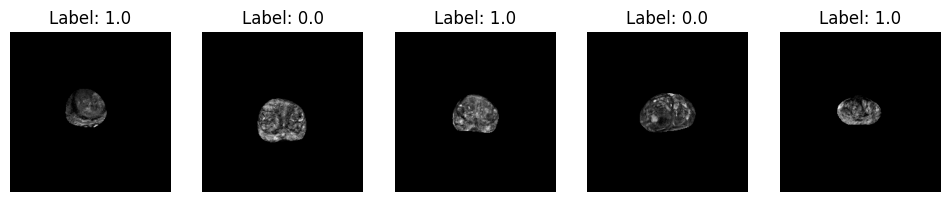

In [8]:
import matplotlib.pyplot as plt

def display_sample(dataset, n_samples=5):
    plt.figure(figsize=(12, 6))
    for images, labels in dataset.take(1):
        for i in range(n_samples):
            ax = plt.subplot(1, n_samples, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.show()

# Display a sample of images and labels from the test dataset
display_sample(test_dataset)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Reduce Dropout add another Conv Layer, add a Dense Layer or 2. Try Adding more Conv and Dense Layers and see if overfits
# Try increasing data shape input shape 
# Autoencoding


def build_model(input_shape, l2_reg_rate=0.003):
    model = Sequential([
        # First conv layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same',
               kernel_regularizer=l2(l2_reg_rate)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second conv layer
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_reg_rate)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),

        # Third conv layer
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_reg_rate)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Fourth conv layer (new layer)
        Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_reg_rate)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flattening followed by Dense layer
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg_rate)),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_reg_rate)),
        Dropout(0.25),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg_rate))  # Output layer for binary classification
    ])
    
    return model


In [10]:
def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC', 'Precision', 'Recall', 'accuracy'])
    

In [11]:
input_shape = (256, 256, 1)  # Example input shape; adjust based on your preprocessed image size
model = build_model(input_shape)
compile_model(model)
model.summary()

/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,586,241 (17.50 MB)

 Trainable params: 4,585,281 (17.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [14]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=60,  # Number of epochs
    callbacks=[early_stopping],  # Add callbacks
    verbose=1  # Show training log
)

Epoch 1/60


2024-04-21 19:18:55.145431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


257/257 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - AUC: 0.5335 - Precision: 0.5933 - Recall: 0.6707 - accuracy: 0.5477 - loss: 2.6243 - val_AUC: 0.5000 - val_Precision: 0.5343 - val_Recall: 1.0000 - val_accuracy: 0.5343 - val_loss: 4.3075
Epoch 2/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - AUC: 0.5901 - Precision: 0.6099 - Recall: 0.9238 - accuracy: 0.6088 - loss: 1.1420 - val_AUC: 0.5000 - val_Precision: 0.5343 - val_Recall: 1.0000 - val_accuracy: 0.5343 - val_loss: 3.1884
Epoch 3/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - AUC: 0.6059 - Precision: 0.6098 - Recall: 0.8953 - accuracy: 0.6065 - loss: 0.8656 - val_AUC: 0.5386 - val_Precision: 0.5380 - val_Recall: 1.0000 - val_accuracy: 0.5411 - val_loss: 0.8516
Epoch 4/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - AUC: 0.5832 - Precision: 0.5956 - Recall: 0.9676 - accuracy: 0.5962 - loss: 0.7995 - val_AUC: 0.5500 - val_Precision: 0.5355 - val_Recall: 1.0000 - val_accuracy: 0.5366 - val_loss: 0.8076
Epoch 5/60
257/257 ━━━━━━━━━━━━

In [18]:
# Assuming test_dataset is your TensorFlow dataset or a generator that yields batches of test data
test_loss, test_auc, test_precision, test_recall, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - AUC: 0.5327 - Precision: 0.6418 - Recall: 0.9947 - accuracy: 0.6403 - loss: 0.6855
Test Loss: 0.69269859790802
Test AUC: 0.5415212512016296
Test Precision: 0.6243550181388855
Test Recall: 0.9942481517791748
Test Accuracy: 0.6232700943946838


In [35]:
print(history.history.keys())


dict_keys(['AUC', 'Precision', 'Recall', 'accuracy', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss'])


In [36]:
# Retrieve the last values of training and validation metrics from history for comparison
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_auc = history.history['AUC'][-1]
final_val_auc = history.history['val_AUC'][-1]

In [37]:
# Extract training and validation metrics across all epochs
epochs = range(1, len(history.history['accuracy']) + 1)  # epoch count
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['AUC']
val_auc = history.history['val_AUC']

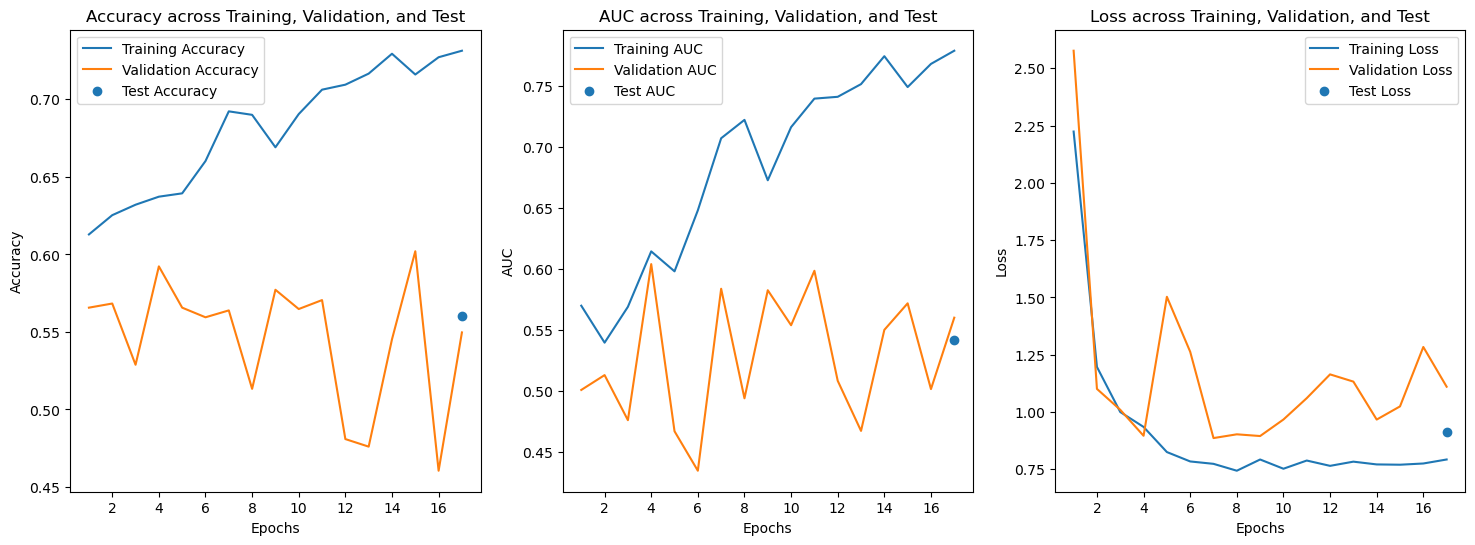

In [38]:
import matplotlib.pyplot as plt

# Create a figure for plotting
plt.figure(figsize=(18, 6))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.scatter(len(train_acc), test_accuracy, label='Test Accuracy')  # Test as point
plt.title('Accuracy across Training, Validation, and Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 2)
plt.plot(epochs, train_auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.scatter(len(train_auc), test_auc, label='Test AUC')  # Test as point
plt.title('AUC across Training, Validation, and Test')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Plot Loss
plt.subplot(1, 3, 3)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.scatter(len(train_loss), test_loss, label='Test Loss')  # Test as point
plt.title('Loss across Training, Validation, and Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [39]:
import numpy as np
from tensorflow.keras.models import Model

# Predict probabilities
pred_probabilities = model.predict(test_dataset)
# Convert probabilities to class labels
pred_labels = np.argmax(pred_probabilities, axis=1)

true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


2024-04-20 14:13:25.984841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_times=1)[0]

print('Best model summary:')
best_model.summary()
print('Best hyperparameters:', best_hyperparameters.values)

In [ ]:
# Calling the tuner_search function with the training and validation datasets
model, history = tuner_search(train_dataset, val_dataset)

# After tuning and training, evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")